In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
import mplcyberpunk
import json
plt.style.use('cyberpunk')

### Perform Individual Student Analysis. 
#### Objectives: 
* Show progress over time
* Show improvement tips

#### To Do with senior batch data:
* Show most correlated senior
* Show tips to improve from best improved senior



In [3]:
ROLLNO = '2023IPM052'
T1 = ["LSE-IA","MIE-I","PHIL-I","DC","SM-I","SOC-I", "ITA"] #Dance/Drama not included because datesheet not found. 

#Meow meow load new idx
IDX = ["Name","Roll No.","Q1","Q2","MT","ET", "CP", "PROJ1", "PROJ2","Final",'GPA']
New_IDX = []
for i in IDX: New_IDX.append(i+'-Numeric')
New_IDX += IDX


In [4]:
#Load term1 data for dance/drama GPA since datasheet not included
term1 = pd.read_excel("Term1-Final-Computed.xlsx", sheet_name='RAW')
term1.fillna(0, inplace=True)
term1.set_index('Roll No.', inplace=True)
term1['Dance/Drama'] = term1['Dance -I'] + term1['Drama- I']
DD = term1['Dance/Drama']

In [5]:
# Load in new data
DATAS = {}

for course in T1:

    avail = []
    df = pd.read_excel('Component-Wise Breakdown latest(AutoRecovered).xlsx', sheet_name=course)
    
    # Get available fields only (discard unnamed and other useless columns)
    for key in df.keys():
        if key in New_IDX: avail.append(key)

    df = df[avail] # Filter dataframe
    assert 'Roll No.' in avail, UserWarning('Roll number necessary')
    df.set_index('Roll No.', inplace=True)

    DATAS[course] = df
DATAS.keys()

dict_keys(['LSE-IA', 'MIE-I', 'PHIL-I', 'DC', 'SM-I', 'SOC-I', 'ITA'])

In [6]:
# print(DATAS['DC'].head())
Weights = {
    'DC': {
        'credits':6,
        'Q1':0.165, 'Q2': 0.165, 'MT':0.335, 'ET':0.335
    },
    'SOC-I': {
        'credits':4,
        'Q1':0.2, 'MT':0.4, 'PROJ1': 0.2, 'CP':0.2
    },
    'SM-I': {
        'credits':6,
        'Q1': 0.1, 'Q2':0.1, 'MT':0.3, 'ET': 0.5
    },
    'PHIL-I': {
        'credits':3,
        'ET':0.5, 'PROJ1':0.3, 'CP':0.2
    },
    'MIE-I': {
        'credits':4,
        'Q1':0.3, 'MT':0.3,'ET':0.3, 'CP':0.1
    },
    'ITA': {
        'credits':2,
        'ET':0.5, 'Q1':0.3, 'CP':0.2
    },
    'LSE-IA': {
        'credits':2,
        'ET':0.4, 'PROJ1':0.2, "PROJ2":0.2, 'CP':0.2
    }
}

dates = pd.read_excel('Component-Wise Breakdown latest(AutoRecovered).xlsx', sheet_name='Dates')
dates.set_index('Dates', inplace=True)
dates

,Sub,Event
Dates,,
2023-09-13,MIE-I,Q1
2023-09-23,DC,Q1
2023-09-25,SM-I,Q1
2023-09-30,MIE-I,MT
2023-10-05,ITA,Q1
2023-10-19,DC,MT
2023-10-20,SM-I,MT
2023-10-21,SOC-I,MT
2023-10-22,ITA,ET


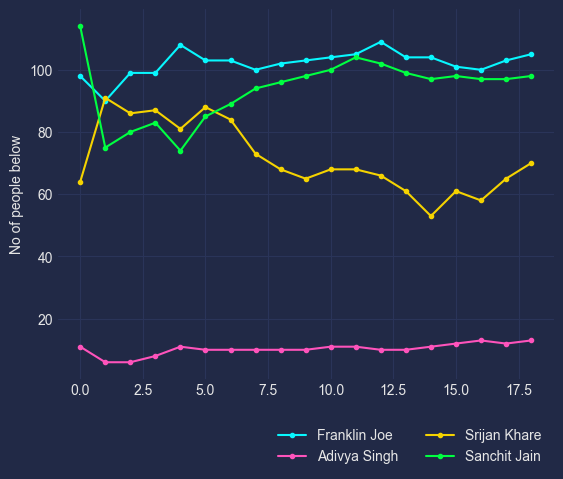

In [150]:
def generate_starting_score(rollnos: list):
    """
    Generates a new series containing tentative scores that calculates CP & Dance/Drama scores only. 

    rollnos: list of roll numbers to generate the series for.
    """
    start_series = pd.Series(index=rollnos)
    for rollno in rollnos:
        start_score = 0
        for sub in Weights.keys():
            if 'CP' in Weights[sub].keys():
                # print(f'Adding {sub} CP score')
                start_score += Weights[sub]['CP'] * Weights[sub]['credits'] * DATAS[sub]['CP-Numeric'][rollno]
        start_score += DD[rollno] * (13/4.33)  # Scale the GPA score to match with the grade 13 scores.
        start_series[rollno] = start_score
        
    return start_series

def _add_new_score(old_scores: pd.Series, event_date):
    """
    INTERNAL FUNCTION: USED BY generate_rank_list
    Takes in a series and creates new tentative score by adding the weighted component scores.

    old_scores: series containing old tentative scores.
    event_date: date at which the event takes place.
    """
    if event_date in dates.index:

        sub = dates['Sub'][event_date]; event = dates['Event'][event_date]
        new_scores = pd.Series(index=old_scores.index).fillna(0) #Create new series with same index as old one. 
        for rollno in old_scores.index:
            # print(DATAS[sub][event+'-Numeric'][rollno])
            new_scores[rollno] =  old_scores[rollno] + (Weights[sub]['credits'] * Weights[sub][event] * DATAS[sub][event+'-Numeric'][rollno])

    return new_scores

def generate_rank_list(start_series, rollno,include_free_time=True, include_date_index=True):
    """
    Generates a list of ranks that the target participant has held over time in order.
    =========================================================================================
    start_series: pd.Series -> that contains the starting tentative scores (generated by generate_starting_score)

    rollno      : str -> roll number of participant who's ranks have to be calculated

    dates       : pd.DataFrame object -> with index as date index and two columns: 'Sub' and 'Event'. 

    include_free_time: bool -> whether to give ranks data for every single day between term start & end or just the days where ranks changed

    include_date_index: bool -> whether to set the index of returned Series as the dates. This will affect the scaling when plotted as dates will provide a more accurate scaling.
    =========================================================================================
    Returns: pandas Series object (columns are dates)

    """
    last_event = start_series  # Set last event object so that it the new score can be added on top of this. 

    # Initialize date sequences based on if user wants all dates or just dates with exam events.
    if include_free_time:  # If user wants all dates
        startdate = '2023-09-01'; end_date=dates.index[len(dates)-1]
        datesequence = pd.date_range(start=startdate, end=end_date)

    else: datesequence = dates.index  # If just exam dates. 
    

    ranks = pd.Series(index=datesequence)  #Initialize series that holds the ranks (to be returned)

    ranks[datesequence[0]] = (159 - start_series.rank(ascending=False)[rollno]) # Input the starting rank (computed by generate_starting_score func)

    #Main loop where each rank is calculated for each date and appended. 
    for eventdate in datesequence:
        if eventdate in dates.index:  # This will always be True if datesequence only contains exam event dates.
            new_event = _add_new_score(last_event, eventdate)
            ranks[eventdate] = (159 - new_event.rank(ascending=False)[rollno])
            last_event = new_event
        else:
            ranks[eventdate] = list(ranks.dropna())[-1]  # Add the last element in this 

    if not include_date_index: ranks.reset_index(inplace=True, drop=True)
    return ranks


# Test generation 

start = generate_starting_score(rollnos=DATAS['DC'].index)

def multi_plot(rollnos: list):
    start = generate_starting_score(rollnos=DATAS['DC'].index)
    for rollno in rollnos:
        plt.plot(generate_rank_list(start, rollno, False, False), label=DATAS['DC']['Name'][rollno].title(),
                  marker='.')
    
    plt.legend(bbox_to_anchor=(1, -0.1), ncol=2)
    plt.ylabel('No of people below')
        
multi_plot(rollnos=['2023IPM052', '2023IPM014', '2023IPM125', '2023IPM106'])

In [ ]:
#Correlation analysis:
# We try to find closest academic rivals by analyzing correlation between rank lists

target = '2023IPM052'

for rollno in DATAS['DC'].index:
    

